In [2]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
num = ['(1)','(2)','(3)','(4)','(5)','(6)','(7)','(8)','(9)','(10)']
dataArr =  np.array([[1,5],[2,2],[3,1],[4,6],[6,8],[6,5],[7,9],[8,7],[9,8],[10,2]])
label = np.array([[1,1,-1,-1,1,-1,1,1,-1,-1]]).T

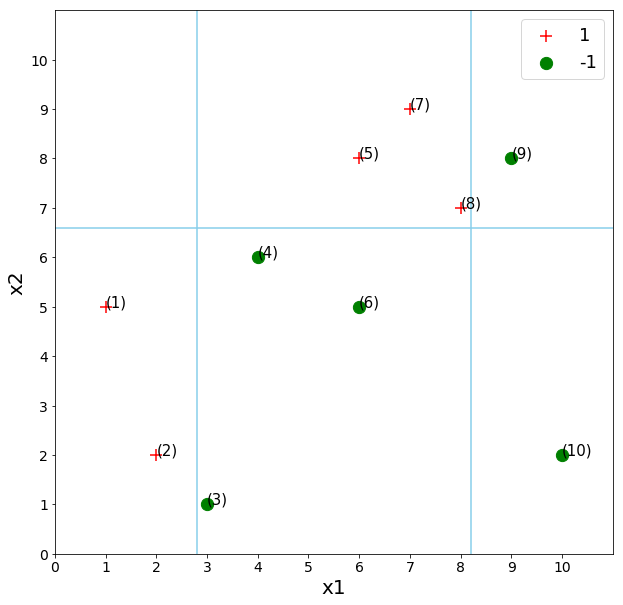

In [3]:
###绘制散点图
plt.figure(figsize=(10,10))
idx_1 = np.where(label==1)
plt.scatter(dataArr[idx_1[0],0],dataArr[idx_1[0],1],c='red',marker='+',label='1',s=150) 
for i in idx_1[0]:
    plt.text(dataArr[i,0],dataArr[i,1],num[i],size = 15)
idx_2 = np.where(label==-1)
plt.scatter(dataArr[idx_2[0],0],dataArr[idx_2[0],1],c='green',marker='o',label='-1',s=150)
for i in idx_2[0]:
    plt.text(dataArr[i,0],dataArr[i,1],num[i],size = 15)
plt.vlines(2.8,-1,11,color='skyblue')
plt.vlines(8.2,-1,11,color='skyblue')
plt.hlines(6.6,-1,11,color='skyblue')
plt.xlabel('x1',fontsize=20)
plt.ylabel('x2',fontsize=20)
plt.xlim((0, 11))
plt.ylim((0, 11))
plt.xticks(np.arange(0, 11, 1))
plt.yticks(np.arange(0, 11, 1))
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(loc = 'upper right',prop={'size': 18})
plt.show()

In [3]:
def stumpClassify(dataArr,dimen,threshVal,threshIneq):
    retArray = np.ones((np.shape(dataArr)[0],1))
    if threshIneq == 'lt':
        retArray[dataArr[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataArr[:,dimen] > threshVal] = -1.0
    return retArray

In [4]:
def buildStump(dataArr,label,D):
    m,n = np.shape(dataArr)    ###m代表样本行数，n代表样本列数
    numSteps = 10.0; bestStump = {}; bestClasEst = np.zeros((m,1))
    minError = 99999999
    ##两列
    for i in range(n):
        rangeMin = dataArr[:,i].min()
        rangeMax = dataArr[:,i].max()
        stepSize = (rangeMax-rangeMin)/numSteps  ##学习步长
        ##步长
        for j in range(-1,int(numSteps)+1):
            ##大于或小于当前阈值
            for temp in ['lt','gt']:
                threshVal = (rangeMin + float(j) * stepSize)   ###遍历所有阈值
                predictedVals = stumpClassify(dataArr,i,threshVal,temp)  ##计算阈值下的单层决策树结果
                errArr = np.ones((m,1))
                errArr[predictedVals == label] = 0  ##统计预测错误的样本
                weightedError = sum(D * errArr)  ##统计分类错误的样本权重和
                ##print "split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f"%(i,threshVal,temp,weightedError)
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = temp
    return bestStump,minError,bestClasEst

In [5]:
def adaBoostTrainDs(dataArr,label,numIt=40):
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.ones((m,1))/m
    aggClassEst = np.zeros((m,1))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,label,D)
        #print "D:",D.T
        alpha = float(0.5*np.log((1.0-error)/max(error,1e-16)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        #print "classEst: ",classEst
        expon = -1*alpha*label*classEst
        D = D*np.exp(expon)
        D = D/D.sum()
        aggClassEst += alpha * classEst
        #print "aggClassEst: ",aggClassEst 
        aggErrors = np.multiply(np.sign(aggClassEst) != label,np.ones((m,1)))
        errorRate = aggErrors.sum()/m
        print "total error: ",errorRate,"\n"
        if errorRate == 0.0: 
            break
    return weakClassArr

In [11]:
def adaClassify(dataArr,classifierArr):
    m = np.shape(dataArr)[0]
    aggClassEst = np.zeros((m,1))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataArr,classifierArr[i]['dim'],classifierArr[i]['thresh'],classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha']*classEst
        #print aggClassEst
    return np.sign(aggClassEst)

In [7]:
###加载数据集
data = np.loadtxt("horseColicTraining2.txt")
dataArr = data[:,0:-1]
label = data[:,-1]
labelNew = label.reshape(np.size(label),1)

In [23]:
classifierArr = adaBoostTrainDs(dataArr,labelNew,10)

total error:  0.2842809364548495 

total error:  0.2842809364548495 

total error:  0.24749163879598662 

total error:  0.24749163879598662 

total error:  0.25418060200668896 

total error:  0.2408026755852843 

total error:  0.2408026755852843 

total error:  0.22073578595317725 

total error:  0.24749163879598662 

total error:  0.23076923076923078 



In [9]:
###加载测试数据集
testData = np.loadtxt("horseColicTest2.txt")
testDataArr = testData[:,0:-1]
testLabel = testData[:,-1]
testLabel = testLabel.reshape(np.size(testLabel),1)

In [24]:
prediction10  = adaClassify(testDataArr,classifierArr)

In [25]:
errArr = np.ones((np.size(testLabel),1))
errArr[prediction10!=testLabel].sum()/np.size(testLabel)

0.23880597014925373